BSE multi-week planning
=====================

The CRC call center has about 200 agents with the following contract types:

- 50% part-time: thet work 4 hours
- 75% part-time: they work 6 hours
- full-time: they work 8 hours

A plan is made each week based on the call forecast based on the following rules

- agents work from monday to sunday
- they work on 4,6,8 hours shifts based on their contract
- they have two rest shift that must be assigned based on the following *rotation matrix*

|    | mon | tue | wed | thu | fri | sat | sun |
|----|-----|-----|-----|-----|-----|-----|-----|
|  1 | .   | .   | .   | .   | .   | R   | R   |
|  2 | .   | .   | .   | .   | .   | R   | R   |
|  3 | .   | .   | .   | R   | R   | .   | .   |
|  4 | .   | R   | R   | .   | .   | .   | .   |
|  5 | .   | .   | .   | R   | R   | .   | .   |
|  6 | .   | .   | .   | .   | .   | R   | R   |
|  7 | .   | .   | .   | .   | .   | R   | R   |
|  8 | .   | .   | .   | .   | .   | R   | R   |
|  9 | R   | R   | .   | .   | .   | .   | .   |
| 10 | .   | .   | R   | R   | .   | .   | .   |

---

- the plan must be **optimal** that is it must follow as closely as possible the target

---

In order to specify these rules we use a simple *domain specific language*:

- **shifts** are defined based on a specification line: for example

```
A1 = Shift.fromSpec("A1", "09:00-12:00")             # a 4 hour shift from 9 to 12
A2 = Shift.fromSpec("A2", "10:00-13:00")             # a 4 hour shift from 9 to 12
...
M1 = Shift.fromSpec("M1", "09:00-12:00,13:00-17:00") # a 8 hour shift from 9 to 17 with a 1 hour pause
...
R  = Shift("R")                                      # a rest shift
```

- shifts can be *combined* to form **shift rules**

```
A1 + A2      # assign either A1 or A2 on a single day

A1 * A2      # a two day assigment: assign A1 on the first day and A2 on the second

(A1+A2) * R  # a two day assignment: assign either A1 or A2 on the first day and R on the second


W = A1 + A2

X = W * W * W * W * W * R * R    # a 7 days assignment:
                                 #   assign either A1 or A2 on the first 5 days
                                 #   assign R on the weekend
```

---

To produce a plan we have to

- define the shifts and the agents and the target staffing
- based on the contract, availability, etc. we find the shifts that can be assigned to an agent
- we create a planner
- we form the shift rules and add them to the planner
- we run the planner
- we retrieve the optimized plan

In [1]:
import json
import matplotlib.pyplot as plt

from random import randint
from datetime import time
from functools import reduce
from tabulate import tabulate

from pywfplan import Shift, StaffPlanner

In [2]:
# first we import the shift specifications
# note that the pauses are specified in the shift definition

with open("shifts_bse.json") as f:
        shifts = [Shift.fromSpec(s[0], *s[1]) for s in json.load(f).items()]

In [3]:
# the rest shift

R = Shift.fromSpec("R")

In [4]:
# the the agent definitions

with open("agents_bse.json") as f:
        agents = json.load(f)

len(agents)

99

In [5]:
# initialize agent cycle

cycle = {agent: randint(0,9) for agent in agents}

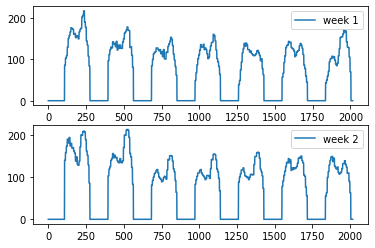

In [6]:
# the target curves from the call forecast
with open("target_bse.json") as f:
        target = json.load(f)

plt.subplot(2, 1, 1)
plt.plot(target["week1"], label="week 1")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(target["week2"], label="week 2")
plt.legend()


Week 1
----------

In [7]:
# create a planner for the first week

week1Planner = StaffPlanner()

In [8]:
# configure the planner

week1Planner.setStaffingTarget(target["week1"], days=7, slot_length=5)

for code, agent in agents.items():
    
    # get work shifts for agent based on her contract
    agent_shifts = [s for s in shifts if s.is_work() and s.attrs["contract"] == agent["contract"]]
    
    W = reduce(lambda a,b: a+b, agent_shifts)
    
    # assign rest based on agent current cycle
    if cycle[code] == 0:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 1:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 2:
        rule = W * W * W * R * R * W * W
    elif cycle[code] == 3:
        rule = W * R * R * W * W * W * W
    elif cycle[code] == 4:
        rule = W * W * W * R * R * W * W
    elif cycle[code] == 5:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 6:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 7:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 8:
        rule = R * R * W * W * W * W * W
    elif cycle[code] == 9:
        rule = W * W * R * R * W * W * W
        
    # finally we add the rule to the planner
    week1Planner.addAgentRule(code, rule)
    
    # and update the agent cycle
    cycle[code] = (cycle[code] + 1) % 10

In [9]:
# at this point the planner is ready to be launched
# (it takes a few minutes)

week1Planner.run(annealing_schedule=0.9, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 16.000000
performing final temperature calibration ...
final temperature: 0.000992
starting 92 simulated annealing steps from temperature 16.0000 (delta=0.9000) ...
  1% T=16.0000 E=4932.4712 (1981 2076) ...
  2% T=14.4000 E=4935.4286 (1981 2079) ...
  3% T=12.9600 E=4947.7659 (1981 2093) ...
  4% T=11.6640 E=4954.2470 (1981 2111) ...
  5% T=10.4976 E=4917.5417 (1981 2110) ...
  6% T=9.4478 E=4940.2431 (1981 2128) ...
  7% T=8.5031 E=4919.7401 (1981 2162) ...
  8% T=7.6528 E=4903.5069 (1981 2186) ...
  9% T=6.8875 E=4950.3452 (1981 2183) ...
 10% T=6.1987 E=4927.3105 (1981 2205) ...
 11% T=5.5789 E=4920.9504 (1981 2237) ...
 13% T=5.0210 E=4922.8274 (1981 2294) ...
 14% T=4.5189 E=4893.8909 (1981 2304) ...
 15% T=4.0670 E=4910.8046 (1981 2348) ...
 16% T=3.6603 E=4892.8294 (1981 2372) ...
 17% T=3.2943 E=4909.4177 (1981 2466) ...
 18% T=2.9648 E=4913.4008 (1981 2448) ...
 19% T=2.6683 E=4903.4504 (1981 2531) ...
 20% T

In [10]:
# retrieve the optimized plan

print(tabulate([[code, *week1Planner.getAgentPlan(code)] for code in agents]))

------  ------------  ------------  ------------  ------------  ------------  ------------  ------------
OIA75   B1530         B1430         B1430         B1430         B1130         R             R
OIA95   C1200_52      R             R             C1200_48      C1200_56      C1200_52      C1230_36
OIA144  C1130_52      C1130_40      R             R             C1030_44      C1200_48      C1200_40
OIA143  C1230_52      C1000_240x48  C1030_240x48  C1000_240x48  C1230_40      R             R
OIA243  C1000_240x48  C1000_240x48  R             R             C1000_240x48  C1200_48      C1330_36
OIA153  C1000_240x48  C1000_240x48  C1200_48      C1000_240x48  C1200_56      R             R
OIA96   C1000_240x48  C0930_240x48  C1000_240x48  R             R             C1200_48      C1330_36
OIA122  C1000_240x48  C0900_240x48  C0900_240x48  C1000_240x48  C1030_240x48  R             R
OIA167  B1100         B1630         B1430         B1030         B1500         R             R
OIA242  B1500        

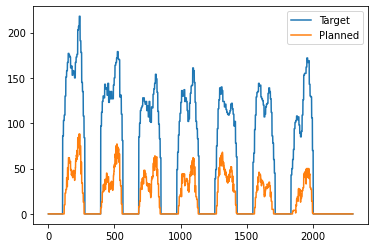

In [11]:
# and compare the planned staffing curve with the target

plt.plot(week1Planner.getTargetStaffing(), label="Target")
plt.plot(week1Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()

In [12]:
# the optimization report 

print(week1Planner.getReport())


          turning length: 7
                 week n°: 0
             slot length: 5 minutes
               agents n°: 99
         target staffing: 11998.50 hrs
      simulated staffing: 3249.17 hrs

   comfort energy weight: 0.00000

         annealing steps: 92
       temperature range: 16.00000 -> 0.00099
    temperature schedule: 0.90
       optimization time: 2.0 minutes

         staffing energy: 4923.88988 -> 4830.62897
          comfort energy: 64573.71429 -> 50333.14286
            TOTAL ENERGY: 4923.88988 -> 4830.62897

     day by day staffing:
                 day   1: 609.83 hrs (target 2177.50 hrs error 71.99%)
                 day   2: 533.33 hrs (target 1913.00 hrs error 72.12%)
                 day   3: 487.17 hrs (target 1635.00 hrs error 70.20%)
                 day   4: 435.67 hrs (target 1619.00 hrs error 73.09%)
                 day   5: 521.83 hrs (target 1506.50 hrs error 65.36%)
                 day   6: 330.67 hrs (target 1572.50 hrs error 78.97%)
            

In [13]:
# save plan for later

week1Plan = {code: week1Planner.getAgentPlan(code) for code in agents}

Week 2
----------

In [14]:
# create a new planner for the second week

week2Planner = StaffPlanner()

In [15]:
# configure the planner

week2Planner.setStaffingTarget(target["week2"], days=7, slot_length=5)

for code, agent in agents.items():
    
    # get work shifts for agent based on her contract
    agent_shifts = [s for s in shifts if s.is_work() and s.attrs["contract"] == agent["contract"]]
    W = reduce(lambda a,b: a+b, agent_shifts)
    
    # assign rest based on agent current cycle
    if cycle[code] == 0:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 1:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 2:
        rule = W * W * W * R * R * W * W
    elif cycle[code] == 3:
        rule = W * R * R * W * W * W * W
    elif cycle[code] == 4:
        rule = W * W * W * R * R * W * W
    elif cycle[code] == 5:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 6:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 7:
        rule = W * W * W * W * W * R * R
    elif cycle[code] == 8:
        rule = R * R * W * W * W * W * W
    elif cycle[code] == 9:
        rule = W * W * R * R * W * W * W
        
    # finally we add the rule to the planner
    week2Planner.addAgentRule(code, rule)
    
    # and update the agent cycle
    cycle[code] = (cycle[code] + 1) % 10

In [16]:
# run planner

week2Planner.run(annealing_schedule=0.9, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 32.000000
performing final temperature calibration ...
final temperature: 0.000992
starting 99 simulated annealing steps from temperature 32.0000 (delta=0.9000) ...
  1% T=32.0000 E=11343.2649 (1981 2060) ...
  2% T=28.8000 E=11349.0843 (1981 2075) ...
  3% T=25.9200 E=11399.0893 (1981 2074) ...
  4% T=23.3280 E=11387.9762 (1981 2072) ...
  5% T=20.9952 E=11358.1181 (1981 2101) ...
  6% T=18.8957 E=11365.8641 (1981 2100) ...
  7% T=17.0061 E=11347.0308 (1981 2108) ...
  8% T=15.3055 E=11322.6815 (1981 2154) ...
  9% T=13.7750 E=11354.4127 (1981 2180) ...
 10% T=12.3975 E=11382.0099 (1981 2177) ...
 11% T=11.1577 E=11336.6657 (1981 2197) ...
 12% T=10.0419 E=11320.6250 (1981 2215) ...
 13% T=9.0377 E=11356.8115 (1981 2282) ...
 14% T=8.1340 E=11305.4812 (1981 2309) ...
 15% T=7.3206 E=11290.3978 (1981 2315) ...
 16% T=6.5885 E=11279.7173 (1981 2370) ...
 17% T=5.9297 E=11296.9534 (1981 2435) ...
 18% T=5.3367 E=11338.95

In [17]:
# retrieve the optimized plan

print(tabulate([[code, *week2Planner.getAgentPlan(code)] for code in agents]))

------  ------------  ------------  ------------  ------------  ------------  --------  ------------
OIA75   B0900         B1700         B1230         R             R             B0900     B1700
OIA95   C0930_240x48  C0900_56      C1030_240x48  R             R             C0900_40  C1400_36
OIA144  C0900_36      C0900_40      C1430_56      C1430_44      C1430_36      R         R
OIA143  R             R             C1430_36      C1430_56      C1430_56      C0900_36  C0900_44
OIA243  C1230_56      C1100_40      C1430_56      C0900_36      C1430_36      R         R
OIA153  C0900_44      C1430_52      C1430_40      C0900_36      C1430_36      R         R
OIA96   C1430_40      R             R             C0900_40      C1430_36      C0900_40  C0900_40
OIA122  C0900_44      C0900_52      C1100_44      C0900_36      C1430_56      R         R
OIA167  B0900         B0900         B1230         B0900         B1230         R         R
OIA242  R             R             B1200         B0900         

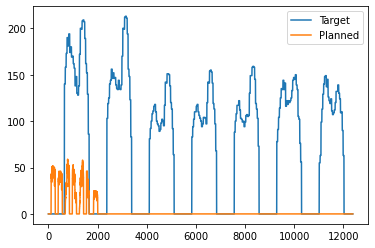

In [18]:
# and compare the planned staffing curve with the target

plt.plot(week2Planner.getTargetStaffing(), label="Target")
plt.plot(week2Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()